What follows is based on the theory in PCA.pdf.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

**RBFKernelPCA** implements kernel PCA using the RBF kernel $k(x, y) = e^{-\frac{\lVert x - y \rVert^2_2}{2\sigma^2}}$ where in the implementation $\text{std} = \sigma$.

In [2]:
class RBFKernelPCA:
  def __init__(self, std):
    self.std = std
    self.kernel = lambda x1, x2: np.exp((-1 / (2 * std ** 2)) * np.sum((x1 - x2) ** 2))
    self.kernel_matrix = lambda X1, X2: np.array([[self.kernel(X1[i], X2[j]) for j in range(X2.shape[0])] 
                                                                             for i in range(X1.shape[0])])   
  def fit(self, train):
    self.train = train
    n = train.shape[0]
    C = np.identity(n) - (1 / n) * np.ones((n, n))
    self.K_train = self.kernel_matrix(train, train)
    self.eigenvectors, self.eigenvalues = np.linalg.svd(C @ self.K_train @ C)[:2]
    
  def transform(self, test):
    n = self.train.shape[0]
    C = np.identity(n) - (1 / n) * np.ones((n, n))
    K_test = self.kernel_matrix(test, self.train)
    centred_K_test = K_test - ((1 / n) * np.ones((K_test.shape[0], n)) @ self.K_train)
    projection = centred_K_test @ C @ self.eigenvectors @ np.diag(1 / (np.sqrt(self.eigenvalues) + 1e-8))
    return projection

**Data**

Generate training and testing concentric circles data.

In [8]:
def circles_data(centres, radiuses, stds, sizes):
  assert len(centres) == len(radiuses) == len(stds) == len(sizes)
  X = np.vstack([[[cx + r * np.cos(theta) + np.random.normal(0, std), 
                   cy + r * np.sin(theta) + np.random.normal(0, std)] 
                  for theta in np.linspace(0, 2 * np.pi, size)] 
                 for (cx, cy), r, std, size in zip(centres, radiuses, stds, sizes)])
  y = np.hstack([i * np.ones(size) for i, size in enumerate(sizes)])
  return X, y

X, y = circles_data(centres = ((5, 5),) * 6, 
                    radiuses = (1, 3.5, 6) * 2, 
                    stds = (0.3,) * 6, 
                    sizes = (100,) * 3 + (20,) * 3)

X_train, y_train = X[:300], y[:300]
X_test, y_test = X[300:], y[300:]

**Plot**

Plot the training and testing data.

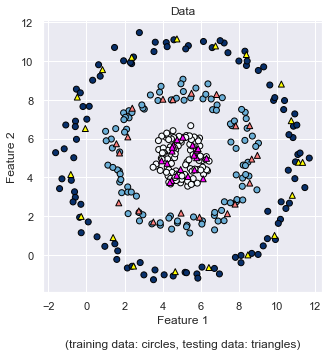

In [9]:
plt.figure(figsize = (5, 5))
plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train, cmap = 'Blues', edgecolor = 'black')
plt.scatter(X_test[:, 0], X_test[:, 1], c = y_test, cmap = 'spring', edgecolor = 'black', marker = '^')
plt.xlabel('Feature 1\n\n(training data: circles, testing data: triangles)')
plt.ylabel('Feature 2')
plt.title('Data')
plt.show()

**Model**

Fit an RBF kernel PCA model to the training data and transform both the training and testing data to obtain low dimensional representations.  

In [10]:
model = RBFKernelPCA(std = 8 ** 0.5)
model.fit(X_train)
train_projection = model.transform(X_train)
test_projection = model.transform(X_test)

**Plot**

Plot the low dimensional representations.

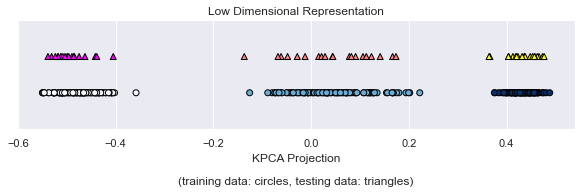

In [11]:
plt.figure(figsize = (10, 2))
plt.gca().get_yaxis().set_visible(False)
plt.scatter(train_projection[:, 0], (1 / 3) * np.ones(train_projection.shape[0]), 
            c = y_train, cmap = 'Blues', edgecolor = 'black')
plt.scatter(test_projection[:, 0], (2 / 3) * np.ones(test_projection.shape[0]), 
            c = y_test, cmap = 'spring', edgecolor = 'black', marker = '^')
plt.xlabel('KPCA Projection\n\n(training data: circles, testing data: triangles)')
plt.title('Low Dimensional Representation')
plt.ylim(0, 1)
plt.show()